# import module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-poster')

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet

import statsmodels.api as sm
import statsmodels
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

from utils import optimal_params, fit_check, reg_feature_select, pca_analysis
SEED = 20221024

# data standardization

In [3]:
df_data = pd.read_csv("../data/data_1.csv")
date = df_data.date
df_data.set_index("date", inplace=True)
df_data.drop('bitcoin_price', axis=1, inplace=True)
df_data = df_data.dropna()

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_data), columns=df_data.columns)

X = df_data.drop('btc_lagged_return', axis=1)
y = df_data.btc_lagged_return.to_frame()

X_scaled = pd.DataFrame(scaler.fit_transform(X),
                        columns=X.columns)

y_scaled = pd.DataFrame(scaler.fit_transform(y),
                        columns=y.columns)

features = X_scaled.columns

In [32]:
X.style.background_gradient(cmap='Blues')

# Lasso regression

In [19]:
param_grid = {
    'max_iter': [10000],
    'alpha': np.linspace(0.001, 0.02 ,100),
    'tol': [1e-1, 1e-2, 1e-3, 1e-4]
}

fold_range = [int(x) for x in np.linspace(2, 30, 10)]
k, best_param, cv_score, model = optimal_params(X_scaled,
                                  y_scaled,
                                  Lasso(),
                                  param_grid,
                                  fold_range,
                                  verbose=0)

print(f"optimal K: {k}")
print(f"best params: {best_param}")
print(f"best cv score(RMSE): {-cv_score}")

optimal K: 2
best params: {'alpha': 0.014434343434343435, 'max_iter': 10000, 'tol': 0.1}
best cv score(RMSE): 0.39359892283224607


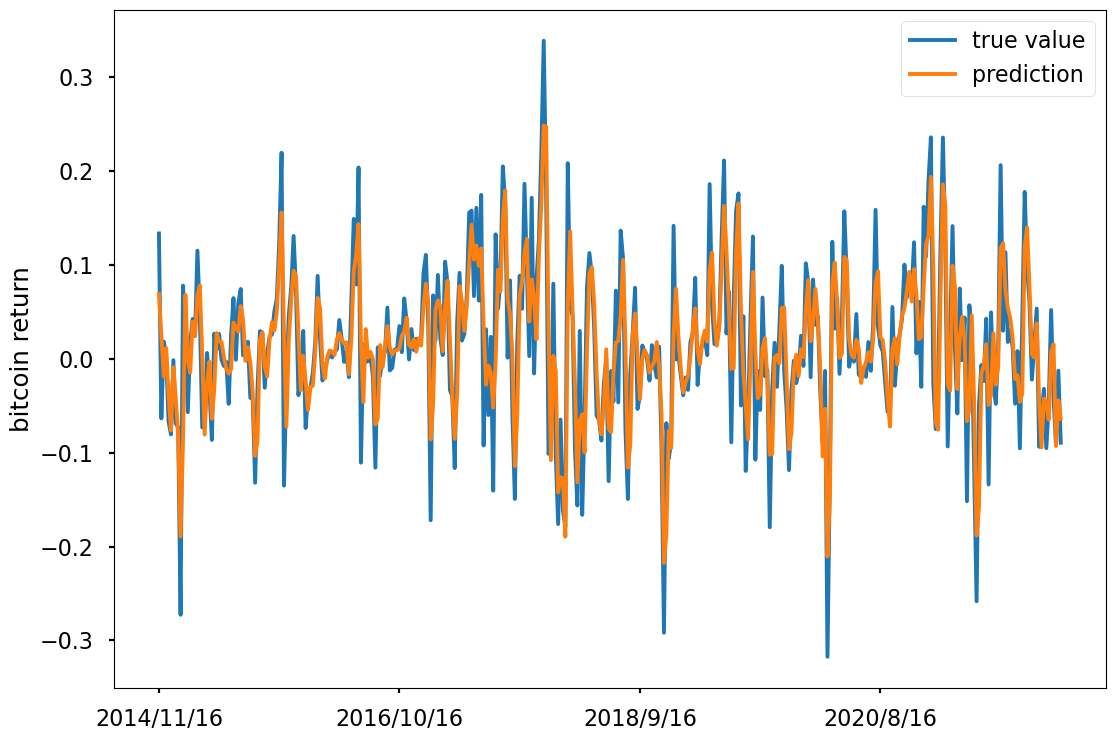

RMSE: 0.048264599563523976


In [20]:
y_pred = pd.DataFrame(model.predict(X_scaled))
y_pred = pd.DataFrame(scaler.inverse_transform(y_pred), columns=y.columns)
print(f"RMSE: {fit_check(y, y_pred)}")

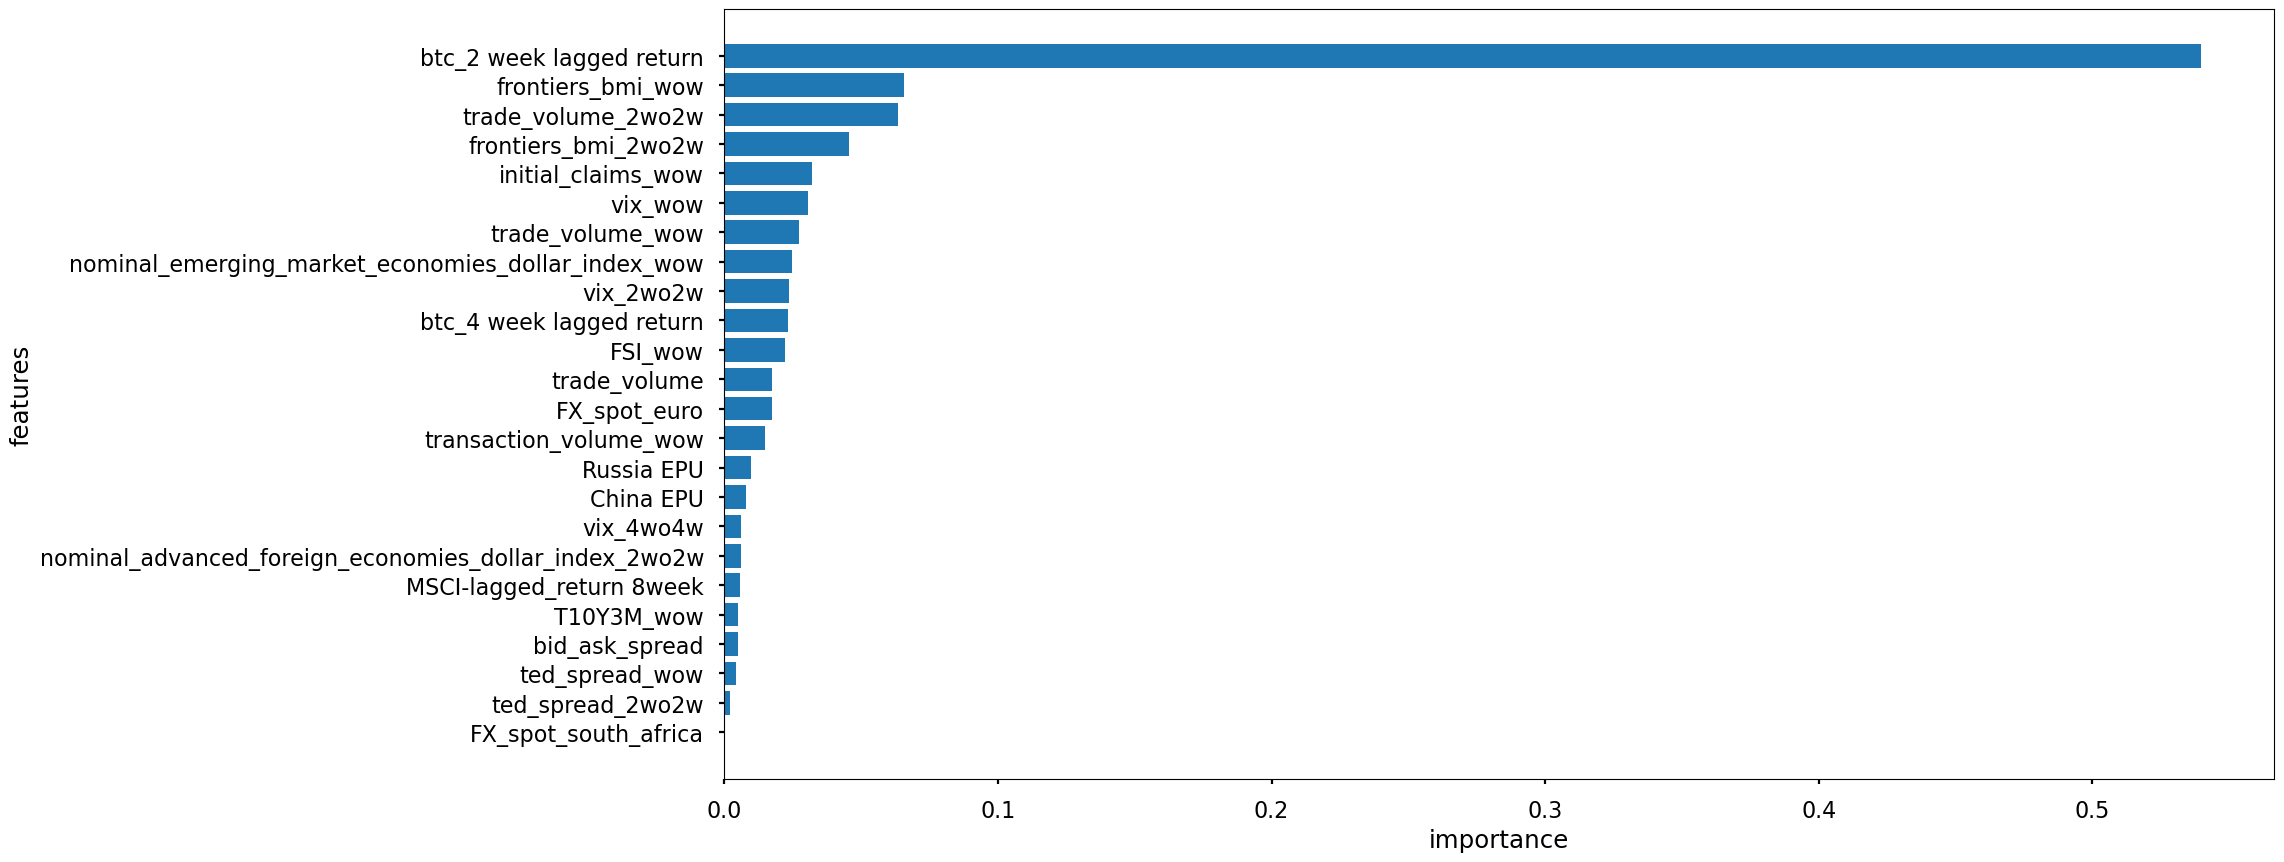

features      coef  \
14                               FX_spot_south_africa  0.000289   
19                                   ted_spread_2wo2w  0.003175   
18                                     ted_spread_wow  0.006471   
21                                     bid_ask_spread -0.007527   
2                                          T10Y3M_wow -0.007542   
0                            MSCI-lagged_return 8week  0.008727   
11  nominal_advanced_foreign_economies_dollar_inde...  0.009333   
17                                          vix_4wo4w  0.009550   
1                                           China EPU -0.012421   
3                                          Russia EPU -0.015128   
9                              transaction_volume_wow -0.023268   
13                                       FX_spot_euro  0.026878   
6                                        trade_volume -0.027094   
20                                            FSI_wow -0.034112   
5                            btc_4 week lagged return -0.035915   
16                                          vix_2wo2w  0.036705   
12  nominal_emerging_market_economies_dollar_index... -0.038453   
7                                    trade_volume_wow  0.042469   
15                                            vix_wow -0.047069   
10                                 initial_claims_wow  0.049802   
23                                frontiers_bmi_2wo2w -0.070541   
8                                  trade_volume_2wo2w -0.098261   
22                                  frontiers_bmi_wow  0.101861   
4                            btc_2 week lagged return  0.835111   

    importance_ratio  
14          0.000187  
19          0.002051  
18          0.004181  
21          0.004864  
2           0.004873  
0           0.005639  
11          0.006030  
17          0.006171  
1           0.008025  
3           0.009775  
9           0.015034  
13          0.017366  
6           0.017506  
20          0.022041  
5           0.023205  
16          0.023716  
12          0.024845  
7           0.027440  
15          0.030412  
10          0.032178  
23          0.045578  
8           0.063488  
22          0.065814  
4           0.539581

In [21]:
lasso_importance = reg_feature_select(model.coef_, features)
lasso_importance

# PCA Lasso

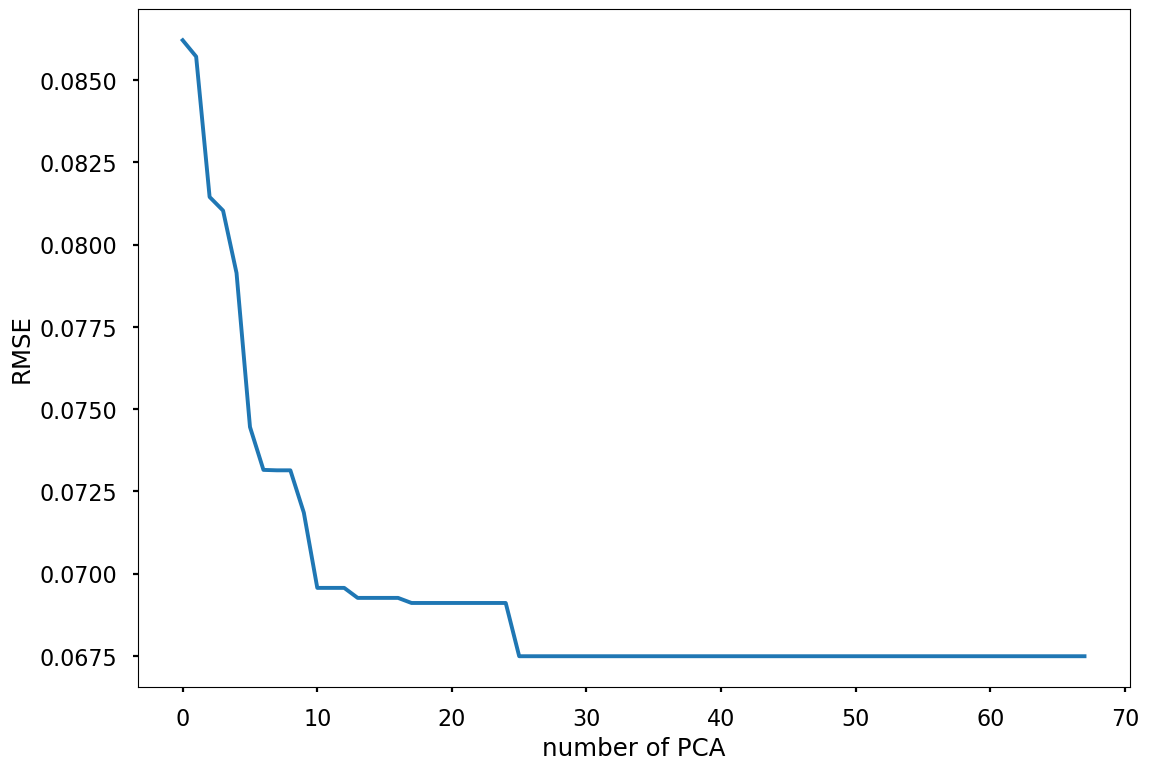

In [11]:
pca_analysis(X_scaled, y, Lasso(**best_param));

# Ridge regression

In [21]:
param_grid = {
    'max_iter': [10000],
    'alpha': np.linspace(5, 30 ,100),
    'tol': [1e-2, 1e-3, 1e-4]
}

fold_range = [int(x) for x in np.linspace(2, 12, 10)]
k, best_param, cv_score = optimal_params(X_scaled,
                                         y_scaled,
                                         Ridge(),
                                         param_grid,
                                         fold_range,
                                         verbose=0)
print(f"optimal K: {k}")
print(f"best params: {best_param}")
print(f"best cv score(RMSE): {-cv_score}")

optimal K: 5
best params: {'alpha': 10.303030303030305, 'max_iter': 10000, 'tol': 0.01}
best cv score(RMSE): 0.6552438885272438


RMSE: 0.046479975436771355


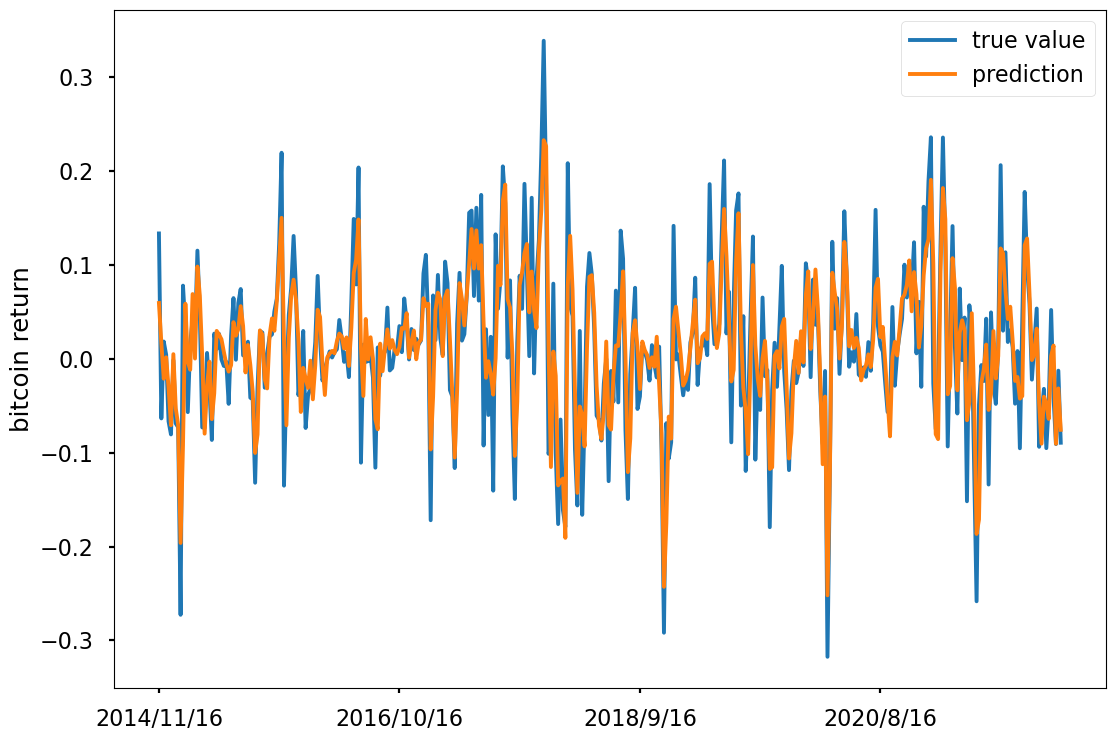

In [22]:
ridge = Ridge(**best_param).fit(X_scaled, y_scaled)

y_pred = pd.DataFrame(ridge.predict(X_scaled))
y_pred = pd.DataFrame(scaler.inverse_transform(y_pred), columns=y.columns)
print(f"RMSE: {fit_check(y, y_pred)}")

features      coef  importance_ratio
67                   vix_wow -0.089352          0.020564
60      FX_spot_south_africa  0.090278          0.020777
27          trade_volume_wow  0.093720          0.021569
33  transaction_volume_2wo2w -0.096460          0.022200
12                 China EPU -0.098163          0.022592
32    transaction_volume_wow -0.106684          0.024553
3         USA Fiscal Policy   0.116361          0.026780
28        trade_volume_2wo2w -0.130322          0.029993
85         frontiers_bmi_wow  0.143495          0.033025
86       frontiers_bmi_2wo2w -0.162686          0.037442
22  btc_2 week lagged return  0.824350          0.189722

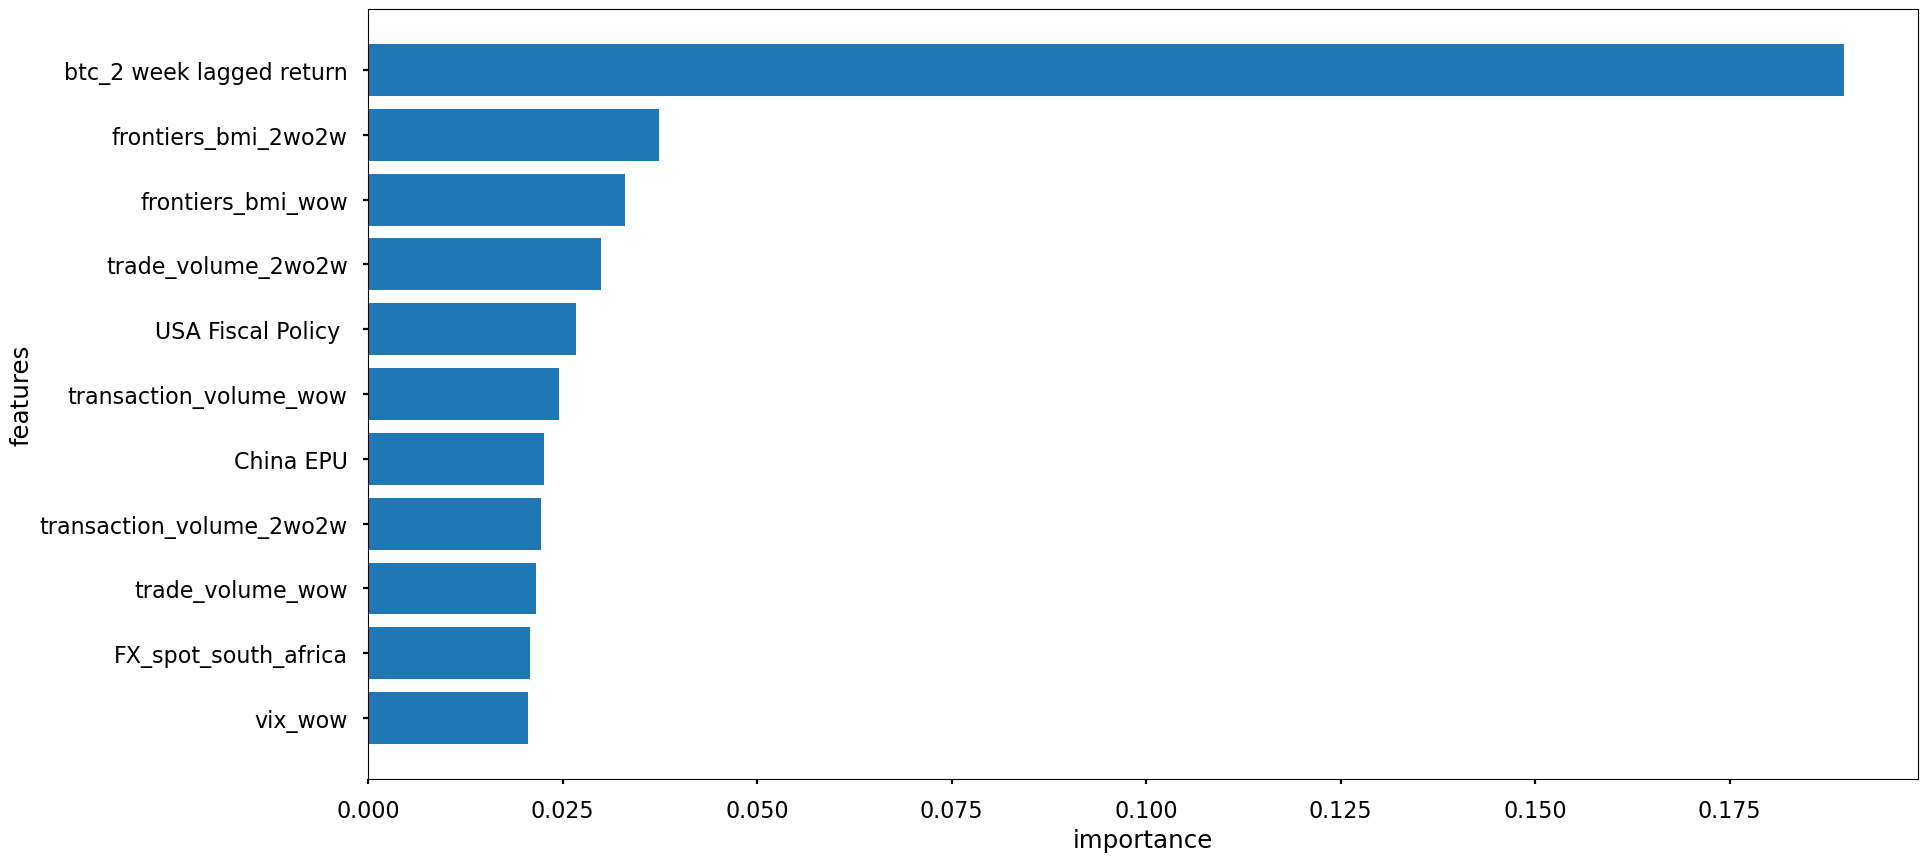

In [23]:
ridge_importance = reg_feature_select(ridge.coef_[0], features, level=0.02)
ridge_importance

# PCA Ridge

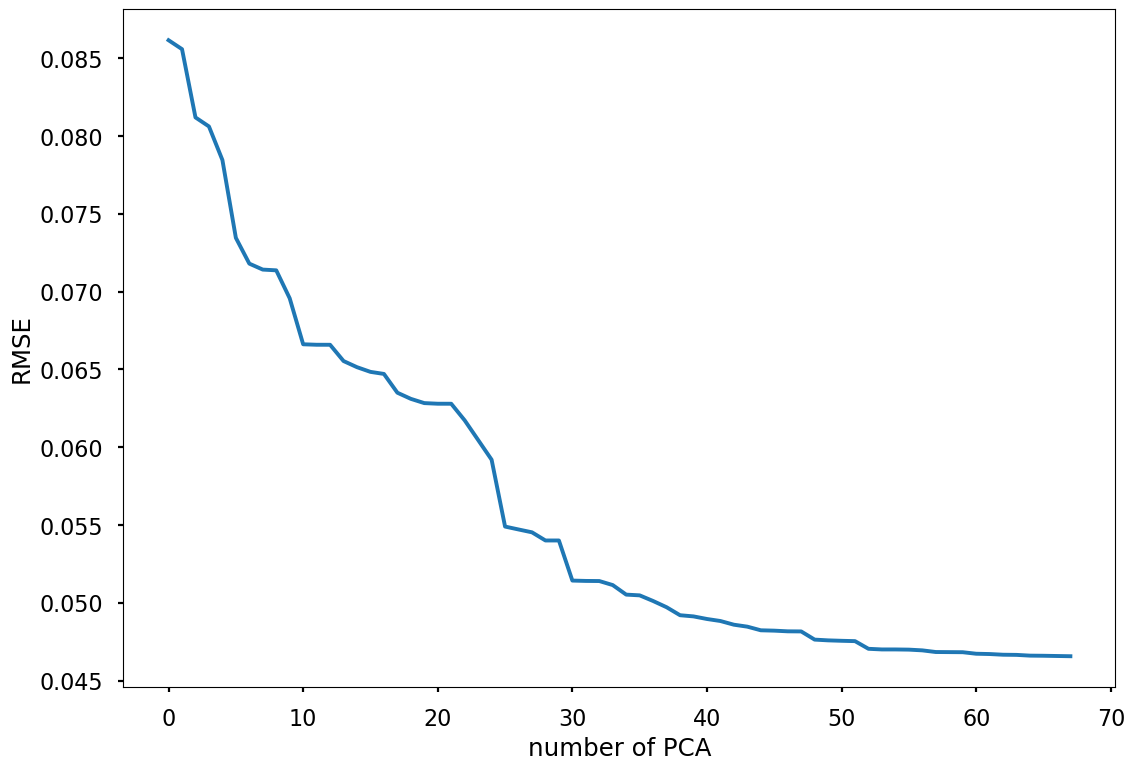

In [24]:
pca_analysis(X_scaled, y, Ridge(**best_param));

# Elastic net

In [41]:
param_grid = {
    'max_iter': [10000],
    'alpha': np.linspace(0.1, 0.25 ,10),
    'tol': [1e-2, 1e-3, 1e-4],
    'l1_ratio': np.linspace(0.5, 1, 4)
}

fold_range = [int(x) for x in np.linspace(8, 13, 6)]
k, best_param, cv_score = optimal_params(X_scaled,
                                         y_scaled,
                                         ElasticNet(),
                                         param_grid,
                                         fold_range,
                                         verbose=0)
print(f"optimal K: {k}")
print(f"best param: {best_param}")
print(f"best cv score: {-cv_score}")

optimal K: 10
best param: {'alpha': 0.18333333333333335, 'l1_ratio': 1.0, 'max_iter': 10000, 'tol': 0.01}
best cv score: 0.50040775305289


RMSE: 0.053550823004766025


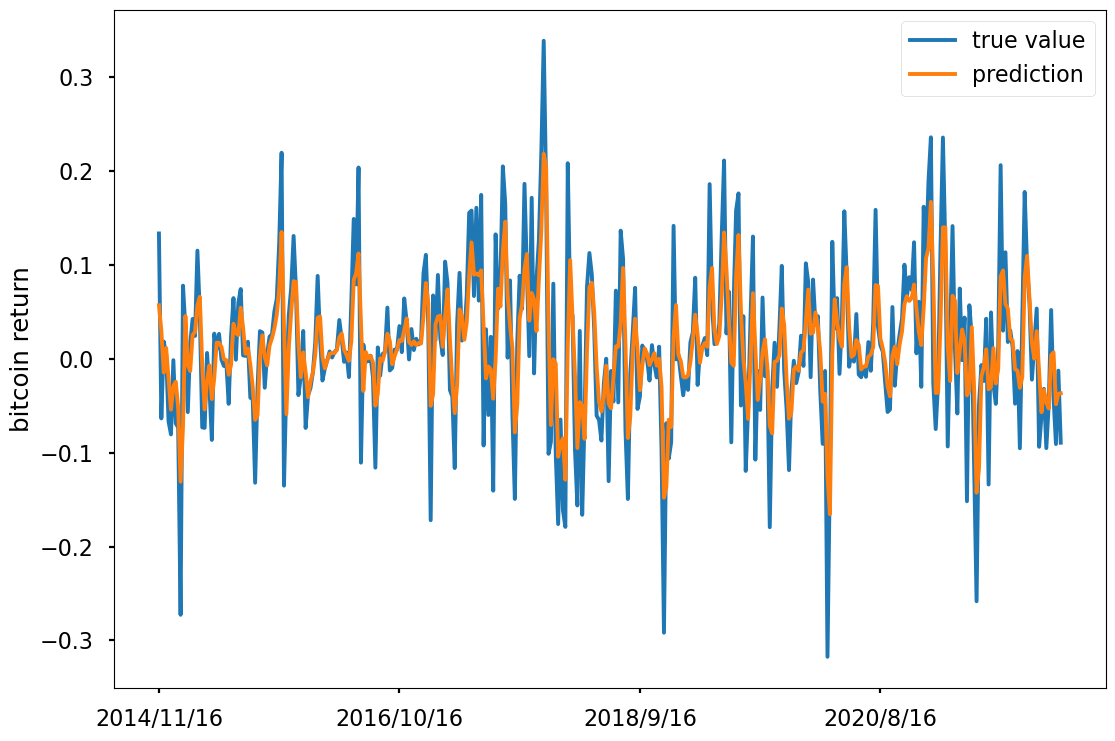

In [42]:
en = ElasticNet(**best_param).fit(X_scaled, y_scaled)

y_pred = pd.DataFrame(en.predict(X_scaled))
y_pred = pd.DataFrame(scaler.inverse_transform(y_pred), columns=y.columns)
print(f"RMSE: {fit_check(y, y_pred)}")

features      coef  importance_ratio
0  btc_2 week lagged return  0.621788               1.0

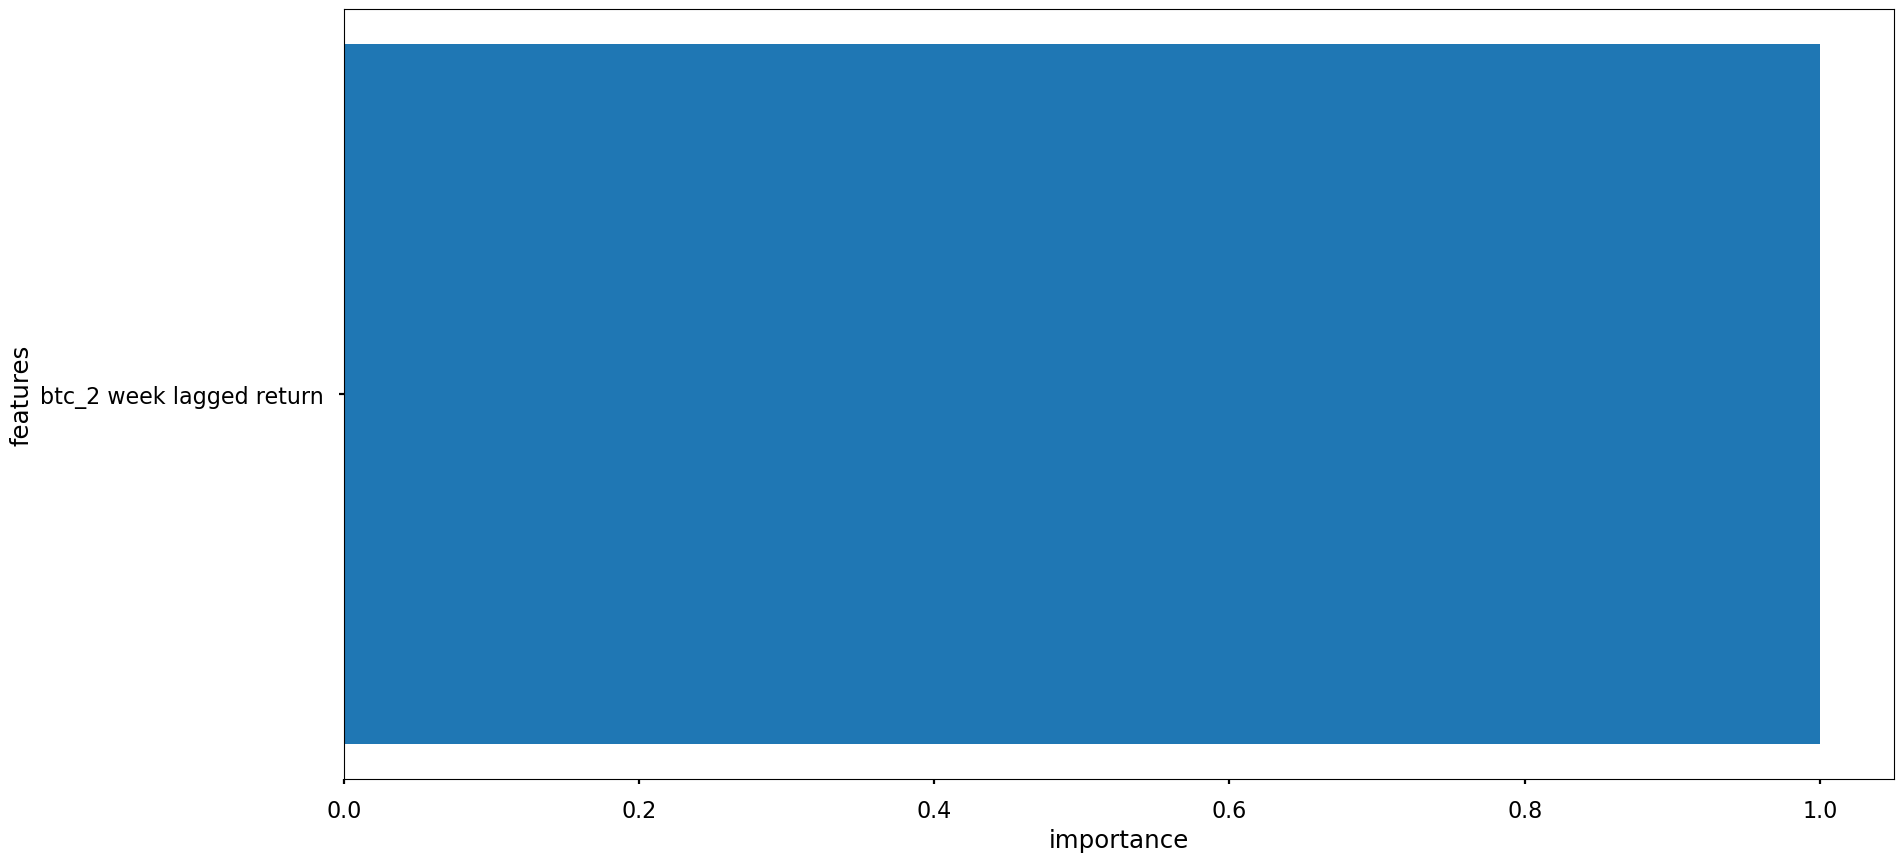

In [43]:
en_importance = reg_feature_select(en.coef_, features)
en_importance

# PCA Elastic Net

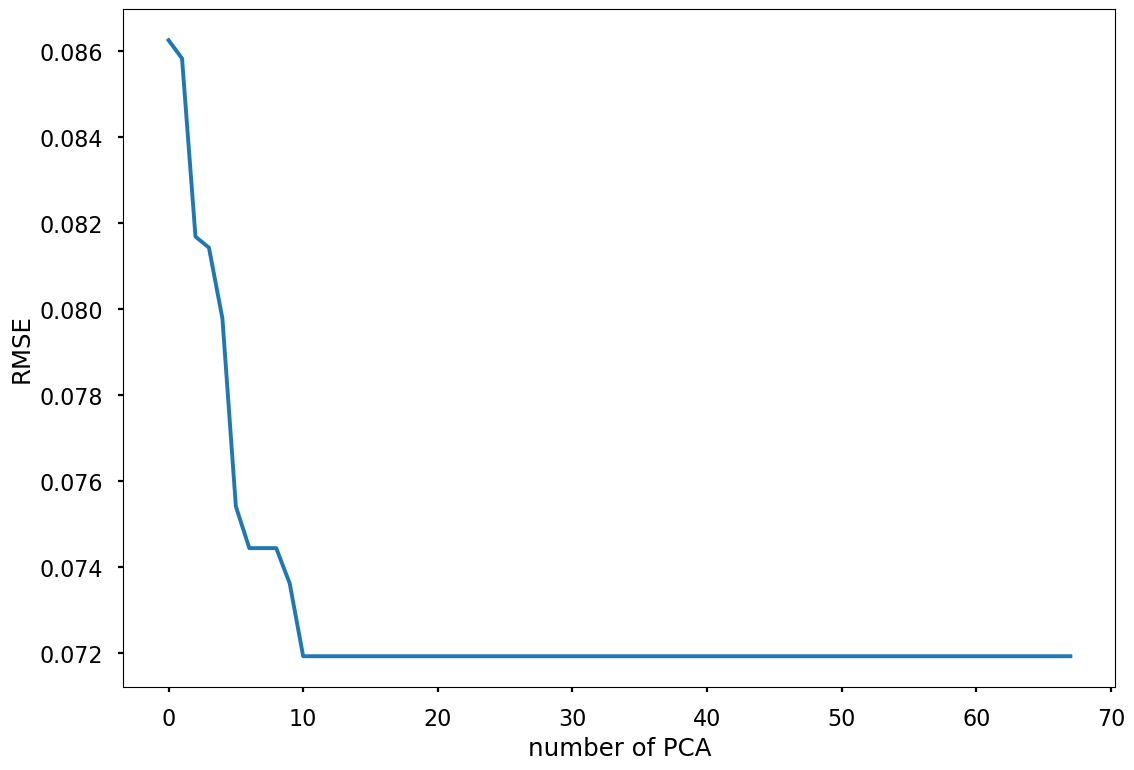

In [45]:
pca_analysis(X_scaled, y, ElasticNet(**best_param));